# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. The model we want to use is:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right), \sigma^2\right) \\
\end{align}


We start with some simple models, see them in the other notebooks.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [3]:
from sklearn.preprocessing import LabelEncoder
from pymc3 import  model_to_graphviz

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

Since the MRF is particularly hard to estimate, we make use of a simpler representation first.

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(1, 1) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau_g^2 & \sim \text{Gamma}(1, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau_g^2) \\
\tau_b^2 & \sim \text{Gamma}(1, 1) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau_b^2) \\
l_{cgs} & \sim \text{Lognormal}(1, 1) \\
x_{cgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left( \beta_{cg} \right) \right) \\
\end{align}

## Data

In [11]:
file_path = os.path.join('../', 'data_raw', 'read_counts-normalized.tsv')

In [92]:
sirna_data = pd.read_csv(file_path, sep="\t")

In [93]:
sirna_data = (sirna_data[["Gene", "sgRNA", "LSLCas9_134", "LSLCas9_136"]]
    .query("Gene != 'Control'")
    .rename(index=str, columns={"LSLCas9_134": "r1", "LSLCas9_136": "r2"})
    .melt(id_vars=['Gene', 'sgRNA'], value_vars=['r1', 'r2'],
          var_name='replicate', value_name='counts')
    .sort_values(['Gene', 'sgRNA', 'replicate'])
)

In [96]:
sirna_data["sgRNA"] = le.fit_transform(sirna_data["sgRNA"].values)

In [97]:
sirna_data[:5]

,Gene,sgRNA,replicate,counts
0,ACSM3,0,r1,8987.015957
900,ACSM3,0,r2,9300.411518
1,ACSM3,1,r1,15742.897879
901,ACSM3,1,r2,15869.905865
2,ACSM3,2,r1,17348.226026


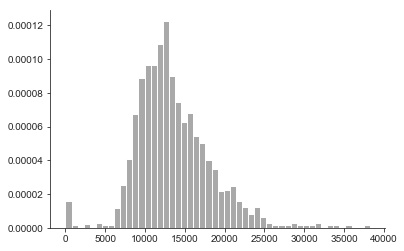

In [29]:
plt.hist(sirna_data[["counts"]].values, color="darkgrey", bins=50, density=True);
plt.show()

In [109]:
sirna_data.query("counts < 200")

,Gene,sgRNA,replicate,counts
78,B4GALT6,78,r1,1.007739
978,B4GALT6,78,r2,1.092367
357,FMO3,357,r1,1.007739
1257,FMO3,357,r2,1.092367
555,MNAT1,555,r1,1.007739
1455,MNAT1,555,r2,1.092367
687,PRPH2,687,r1,1.007739
1587,PRPH2,687,r2,1.092367
777,SEL1L2,777,r1,12.092867
1677,SEL1L2,777,r2,30.586272


Since it is always _both_ replicates that have a low read count, it is safe to assume that these are no batch effects.

## Inference

In [131]:
sirna_data[:20]

,Gene,sgRNA,replicate,counts
0,ACSM3,0,r1,8987.015957
900,ACSM3,0,r2,9300.411518
1,ACSM3,1,r1,15742.897879
901,ACSM3,1,r2,15869.905865
2,ACSM3,2,r1,17348.226026
902,ACSM3,2,r2,17373.002676
3,ACSM3,3,r1,9330.654939
903,ACSM3,3,r2,9374.692465
4,ACSM3,4,r1,8995.077869
904,ACSM3,4,r2,9365.953530


In [126]:
sirna_data.shape

(1800, 4)

In [102]:
gene_idx = le.fit_transform(sirna_data["Gene"].values)
len_genes = len(np.unique(gene_idx))

In [104]:
len_genes

90

In [103]:
gene_idx

array([ 0,  0,  0, ..., 89, 89, 89])

In [105]:
len_conditions = 1

In [111]:
len_sirnas = len(np.unique(sirna_data["sgRNA"].values))
len_sirnas

900

In [133]:
len_sirnas_per_gene = int(len_sirnas / len_genes)
len_sirnas_per_gene

10

In [112]:
len_replicates = len(np.unique(sirna_data["replicate"].values))
len_replicates

2

In [127]:
beta_idx = np.repeat(range(len_genes), len_conditions)
beta_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89])

In [136]:
beta_data_idx = np.repeat(beta_idx, len_replicates * len_sirnas_per_gene)
beta_data_idx[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [141]:
l_idx = np.repeat(range(len_genes * len_conditions * len_sirnas_per_gene), len_replicates)
l_idx

array([  0,   0,   1, ..., 898, 899, 899])

In [150]:
counts = np.squeeze(sirna_data[["counts"]].values)
counts[:10]

array([ 8987.01595723,  9300.41151812, 15742.89787888, 15869.90586508,
       17348.22602643, 17373.00267609,  9330.65493922,  9374.69246518,
        8995.07786883,  9365.95353023])

In [148]:
with pm.Model() as model:
    p = pm.Dirichlet('p', a=np.array([1., 1.]), shape=2)
    p_min_pot = pm.Potential('p_pot', tt.switch(tt.min(p) < .05, -np.inf, 0))
    category = pm.Categorical('category', p=p, shape=len_genes)
    
    tau_g = pm.Gamma('tau_g', 1., 1., shape=1)
    mean_g = pm.Normal('mu_g', mu=np.array([0, 0]), sd=.5, shape=2)
    mean_order_pot = pm.Potential('mop', tt.switch(mean_g[1] - mean_g[0] < 0, -np.inf, 0))    
    gamma = pm.Normal('gamma', mean_g[category], tau_g, shape=len_genes)
    
    tau_b = pm.Gamma('tau_b', 1., 1., shape=1)
    beta = pm.Normal('beta', gamma[beta_idx], tau_b, shape=len(beta_idx))
    l = pm.Lognormal('l', 0, .25, shape = len_sirnas)
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(beta[beta_data_idx]) * l[l_idx] ,
        observed=counts)

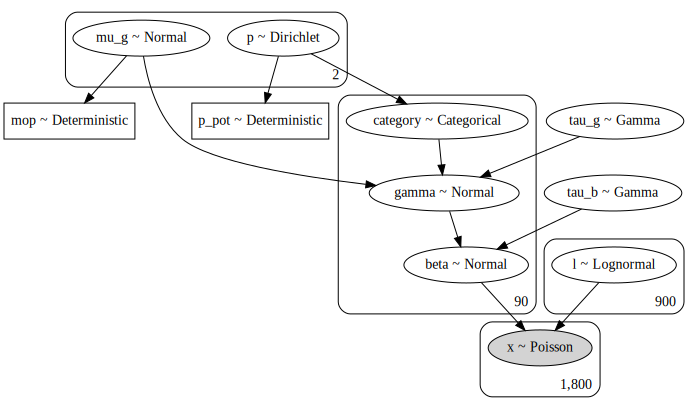

In [149]:
model_to_graphviz(model)

In [152]:
with model:
    trace = pm.sample(10000, tune=1000, n_init=10000, init="advi", random_seed=23)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [l, beta, tau_b, gamma, mu_g, tau_g, p]
>BinaryGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 22000/22000 [1:09:10<00:00,  2.37draws/s]
There were 1437 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7067871783921574, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.12532512724851755, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [153]:
trace_1 = pm.save_trace(trace)

In [155]:
az.rhat(trace)

<xarray.Dataset>
Dimensions:         (beta_dim_0: 90, category_dim_0: 90, gamma_dim_0: 90, l_dim_0: 900, mu_g_dim_0: 2, p_dim_0: 2, tau_b_dim_0: 1, tau_g_dim_0: 1)
Coordinates:
  * category_dim_0  (category_dim_0) int64 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * mu_g_dim_0      (mu_g_dim_0) int64 0 1
  * gamma_dim_0     (gamma_dim_0) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * beta_dim_0      (beta_dim_0) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * p_dim_0         (p_dim_0) int64 0 1
  * tau_g_dim_0     (tau_g_dim_0) int64 0
  * tau_b_dim_0     (tau_b_dim_0) int64 0
  * l_dim_0         (l_dim_0) int64 0 1 2 3 4 5 6 ... 894 895 896 897 898 899
Data variables:
    category        (category_dim_0) float64 1.0 1.01 1.01 ... 1.01 1.02 1.02
    mu_g            (mu_g_dim_0) float64 1.41 1.5
    gamma           (gamma_dim_0) float64 1.93 1.25 1.28 3.52 ... 2.69 3.11 1.02
    beta            (beta_dim_0) float64 3.38 1.14 12.53 1.91 ... 3.16 2.37 2.49
    p               (p_dim_0) fl

In [156]:
az.effective_sample_size(trace)

<xarray.Dataset>
Dimensions:         (beta_dim_0: 90, category_dim_0: 90, gamma_dim_0: 90, l_dim_0: 900, mu_g_dim_0: 2, p_dim_0: 2, tau_b_dim_0: 1, tau_g_dim_0: 1)
Coordinates:
  * category_dim_0  (category_dim_0) int64 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * mu_g_dim_0      (mu_g_dim_0) int64 0 1
  * gamma_dim_0     (gamma_dim_0) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * beta_dim_0      (beta_dim_0) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * p_dim_0         (p_dim_0) int64 0 1
  * tau_g_dim_0     (tau_g_dim_0) int64 0
  * tau_b_dim_0     (tau_b_dim_0) int64 0
  * l_dim_0         (l_dim_0) int64 0 1 2 3 4 5 6 ... 894 895 896 897 898 899
Data variables:
    category        (category_dim_0) float64 248.0 167.0 142.0 ... 136.0 84.0
    mu_g            (mu_g_dim_0) float64 9.0 2.0
    gamma           (gamma_dim_0) float64 5.0 6.0 6.0 1.0 ... 5.0 1.0 1.0 63.0
    beta            (beta_dim_0) float64 1.0 9.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    p               (p_dim_0) float

In [170]:
beta_data_idx[:21]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [172]:
l_idx[:21]

array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
        8,  9,  9, 10])

In [169]:
sirna_data[:21]

,Gene,sgRNA,replicate,counts
0,ACSM3,0,r1,8987.015957
900,ACSM3,0,r2,9300.411518
1,ACSM3,1,r1,15742.897879
901,ACSM3,1,r2,15869.905865
2,ACSM3,2,r1,17348.226026
902,ACSM3,2,r2,17373.002676
3,ACSM3,3,r1,9330.654939
903,ACSM3,3,r2,9374.692465
4,ACSM3,4,r1,8995.077869
904,ACSM3,4,r2,9365.953530


In [173]:
with pm.Model() as model2:
    #p = pm.Dirichlet('p', a=np.array([1., 1.]), shape=2)
    #p_min_pot = pm.Potential('p_pot', tt.switch(tt.min(p) < .05, -np.inf, 0))
    #category a= pm.Categorical('category', p=p, shape=len_genes)
    
    tau_g = pm.Gamma('tau_g', 1., 1., shape=1)
    #mean_g = pm.Normal('mu_g', mu=np.array([0, 0]), sd=.5, shape=2)
    #mean_order_pot = pm.Potential('mop', tt.switch(mean_g[1] - mean_g[0] < 0, -np.inf, 0))    
    gamma = pm.Normal('gamma', 0, tau_g, shape=len_genes)
    
    #tau_b = pm.Gamma('tau_b', 1., 1., shape=1)
    #beta = pm.Normal('beta', gamma[beta_idx], tau_b, shape=len(beta_idx))
    l = pm.Lognormal('l', 0, .25, shape = sirna_data.shape[0])
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(gamma[beta_data_idx]) * l[l_idx] ,
        observed=counts)

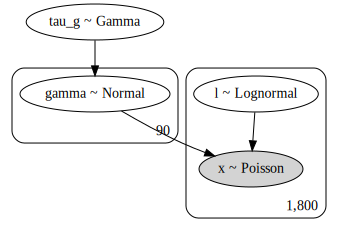

In [174]:
model_to_graphviz(model2)

Final model

In [5]:
infile = "/home/simon/PROJECTS/cell_lines/src/shm/data_raw/read_counts-normalized.tsv"

In [6]:
def _load_data(infile):    
    dat = pd.read_csv(infile, sep="\t")
    dat = (dat[["Condition", "Gene", "sgRNA", "r1", "r2"]]
           .query("Gene != 'Control'")
           .melt(id_vars=["Gene", "Condition", "sgRNA"],
                 value_vars=["r1", "r2"],
                 var_name="replicate",
                 value_name="counts")
           .sort_values(["Gene", "Condition", "sgRNA", "replicate"])
    )
    dat["sgRNA"] = LabelEncoder().fit_transform(dat["sgRNA"].values)
    dat["counts"] = sp.floor(dat["counts"].values)
    return dat

In [7]:
read_counts = _load_data(infile)
read_counts = read_counts.query("Gene == 'POLR3K' | Gene == 'BCR'")

In [8]:
def shm(read_counts: pd.DataFrame):
    n, _ = read_counts.shape
    le = LabelEncoder()

    gene_idx = le.fit_transform(read_counts["Gene"].values)
    con_idx = le.fit_transform(read_counts["Condition"].values)

    len_genes = len(sp.unique(gene_idx))
    len_conditions = len(sp.unique(con_idx))
    len_sirnas = len(sp.unique(read_counts["sgRNA"].values))
    len_replicates = len(sp.unique(read_counts["replicate"].values))
    len_sirnas_per_gene = int(len_sirnas / len_genes)

    beta_idx = np.repeat(range(len_genes), len_conditions)
    beta_data_idx = np.repeat(beta_idx, int(n / len(beta_idx)))

    l_idx = np.repeat(
      range(len_genes * len_conditions * len_sirnas_per_gene), len_replicates
    )

    with pm.Model() as model:
        p = pm.Dirichlet("p", a=np.array([1.0, 1.0]), shape=2)
        pm.Potential("p_pot", tt.switch(tt.min(p) < 0.05, -np.inf, 0))
        category = pm.Categorical("category", p=p, shape=len_genes)

        tau_g = pm.Gamma("tau_g", 1.0, 1.0, shape=1)
        mean_g = pm.Normal("mu_g", mu=np.array([0, 0]), sd=0.5, shape=2)
        pm.Potential("m_opot", tt.switch(mean_g[1] - mean_g[0] < 0, -np.inf, 0))
        gamma = pm.Normal("gamma", mean_g[category], tau_g, shape=len_genes)

        tau_b = pm.Gamma("tau_b", 1.0, 1.0, shape=1)
        if len_conditions == 1:
            beta = pm.Deterministic("beta", gamma)
        else:
            beta = pm.Normal("beta", gamma[beta_idx], tau_b,
                             shape=len(beta_idx))
        l = pm.Lognormal("l", 0, 0.25, shape=len_sirnas)

        pm.Poisson(
          "x",
          mu=np.exp(beta[beta_data_idx]) * l[l_idx],
          observed=sp.squeeze(read_counts["counts"].values),
        )

    return model

In [9]:
model = shm(read_counts)

In [10]:
with model:
    trace = pm.sample(
      100,
      tune=50,
      init="advi",
      n_init=100,
      chains=4,
      random_seed=42,
      progressbar=True,
      discard_tuned_samples=False)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [l, tau_b, gamma, mu_g, tau_g, p]
>BinaryGibbsMetropolis: [category]
Sampling 4 chains: 100%|██████████| 600/600 [00:23<00:00,  4.17draws/s] 
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9521506868904034, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9801063698798614, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameteriz

In [309]:
chains = trace.get_values("gamma")

In [328]:
sp.unique(read_counts.Gene)[beta_idx]

NameError: name 'beta_idx' is not defined

In [12]:
s = _[0]

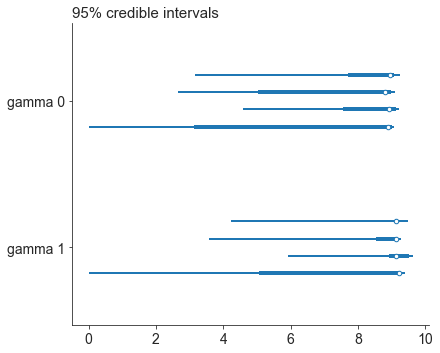

In [62]:
fig, _ = az.plot_forest(trace, var_names="gamma", credible_interval=0.95,  linewidth=2)
_[0].set_title('')
_[0].set_title('95% credible intervals', size=15, loc="left")
_[0].spines['left'].set_visible(True)
_[0].tick_params()

In [ ]:
df.pivot(index='gene_symbol',columns='sample_id',values='fc')

In [350]:
sa = df[["samples", "chain", "idxx"]].pivot(index= "idxx", columns="chain")

In [351]:
sa.values

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [9.25723025, 9.15196775, 9.24743285, 9.25034249],
       [9.2613461 , 9.15475247, 9.24673096, 9.24968242],
       [9.24992721, 9.13620587, 9.28874066, 9.24908049]])

In [224]:
 cols = sns.color_palette("mako_r", 4).as_hex()

In [355]:
sns.cubehelix_palette(4, start=.5, rot=-.75).as_hex()

['#d7dfc0', '#75b490', '#426c84', '#2c1e3e']

In [312]:
df

,samples,chain,idx,idxx
0,0.000000,1,0,0
0,0.000000,1,0,1
0,0.000000,1,0,2
0,0.000000,1,0,3
1,0.000000,1,0,4
1,0.000011,1,0,5
1,0.000009,1,0,6
1,0.000014,1,0,7
2,0.000258,1,0,8
2,0.000771,1,0,9


In [272]:
df["idxx"] = np.tile(range(int(chains.shape[0] / 4)), trace.nchains)

NameError: name 'pl' is not defined

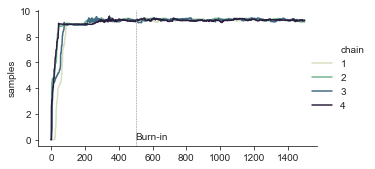

In [297]:
from pylab import rcParams
rcParams['figure.figsize'] = [5, 2.5]

fig, ax = plt.subplots()

sns.lineplot(x="idxx", y="samples", data=df, hue='chain'  ,palette=sns.cubehelix_palette(4, start=.5, rot=-.75))

plt.axvline(500,  linestyle='--', linewidth=.5, color="grey")
plt.annotate("Burn-in", (500, 0))
plt.xlabel("")
leg = plt.legend(bbox_to_anchor=(.95, 0.5), loc="center left", frameon=False)
leg._legend_box.align = "left"
#plt.tight_layout()
pl.xlabel("")
plt.title("Gamma 0", loc="Left")
plt.savefig("test.pdf")
plt.close()


Text(0.0, 1.0, 'Gamma 0')

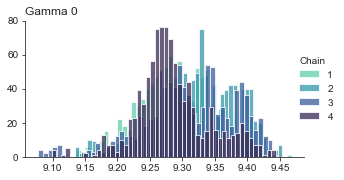

In [299]:
from pylab import rcParams
rcParams['figure.figsize'] = [5, 2.5]

fig, ax = plt.subplots()
ax.hist(chains[501:1500], 50, color=cols[0], label="1", alpha=.75)
ax.hist(chains[2001:3000], 50, color=cols[1], label="2",  alpha=.75)
ax.hist(chains[3501:4500], 50, color=cols[2], label="3",  alpha=.75)
ax.hist(chains[5001:], 50, color=cols[3], label="4",  alpha=.75)

leg = plt.legend(title="Chain", bbox_to_anchor=(.95, 0.5), loc="center left", frameon=False)
leg._legend_box.align = "left"
#plt.tight_layout()
plt.title("Gamma 0", loc="Left")


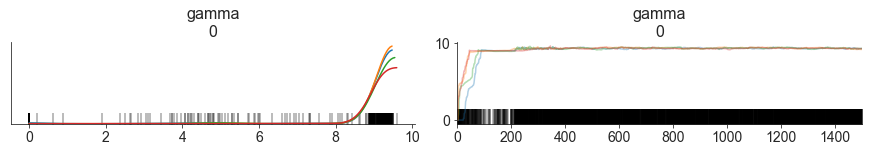

In [93]:
az.plot_trace(trace, var_names="gamma", coords = {'gamma_dim_0': [0]});

In [82]:
s = s[0,0]

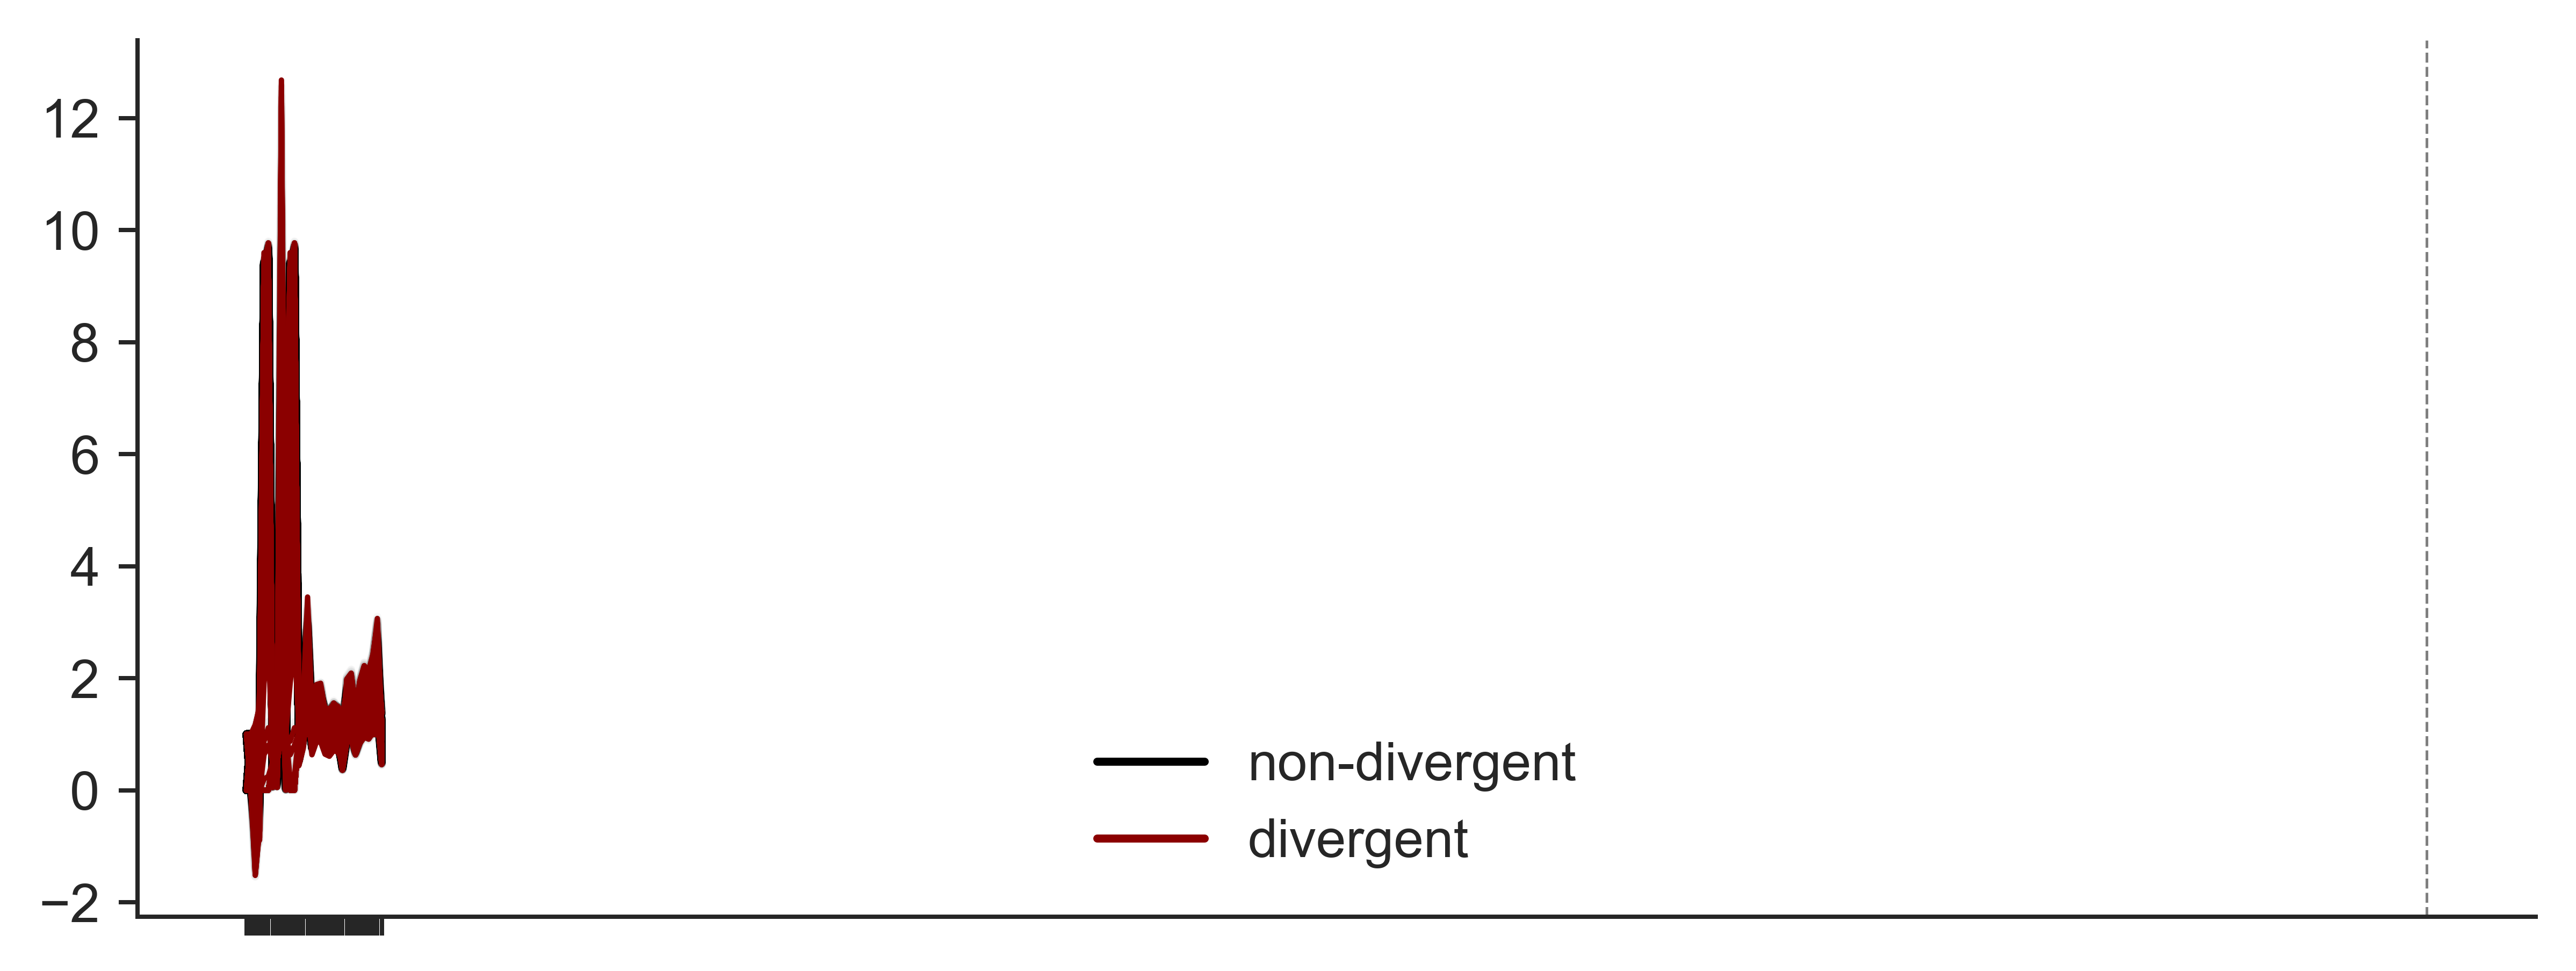

In [366]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=720)
az.plot_parallel(trace, ax=ax, colord="darkred",  colornd='black')
ax.xaxis.set_ticklabels([])
plt.axvline(500,  linestyle='--', linewidth=.5, color="grey")
ax.legend(frameon=False)
plt.ax
plt.show()

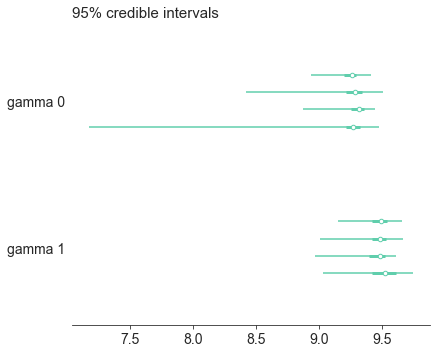

In [474]:
fig, axes = az.plot_forest(trace, var_names="gamma", credible_interval=0.95, )
axes[0].set_title('');
axes[0].set_title('95% credible intervals', size=15, loc="left");
plt.show()

In [ ]:
fig.sa

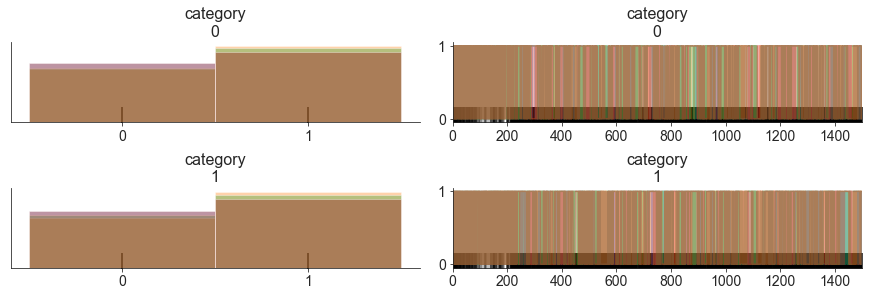

In [32]:
az[0, 0].

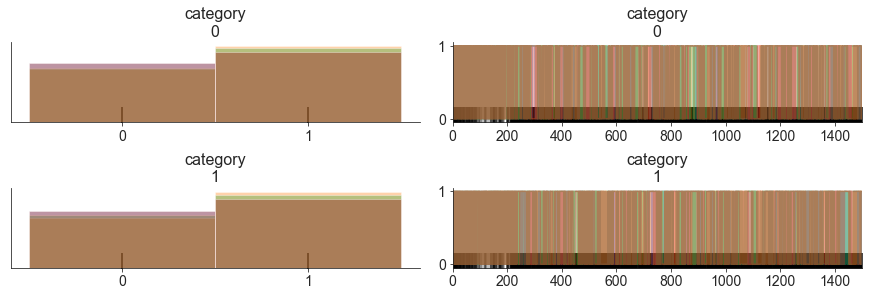

In [38]:
s = az[1, 0]
s.
s.figure

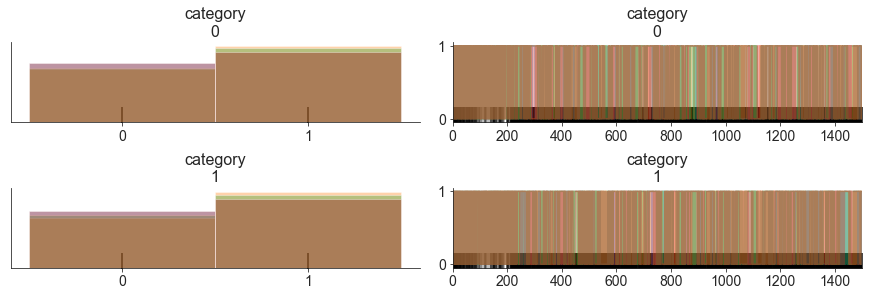

In [26]:
hat  = az.rhat(trace)

In [27]:
s = hat.gamma

In [30]:
k = s.to_dataframe()

In [34]:
k["gamma"]

gamma_dim_0
0    1.04
1    1.03
Name: gamma, dtype: float64

In [374]:
from arviz import convert_to_dataset
from arviz.plots.plot_utils import xarray_to_ndarray
from arviz.plots.plot_utils import get_coords

In [369]:
divergent_data = convert_to_dataset(trace, group="sample_stats")
_, diverging_mask = xarray_to_ndarray(divergent_data, var_names=("diverging",), combined=True)
diverging_mask = np.squeeze(diverging_mask)

In [372]:
def _var_names(var_names, data):
    if var_names is not None:

        if isinstance(var_names, str):
            var_names = [var_names]

        if isinstance(data, (list, tuple)):
            all_vars = []
            for dataset in data:
                dataset_vars = list(dataset.data_vars)
                for var in dataset_vars:
                    if var not in all_vars:
                        all_vars.append(var)
        else:
            all_vars = list(data.data_vars)

        excluded_vars = [i[1:] for i in var_names if i.startswith("~") and i not in all_vars]

        all_vars_tilde = [i for i in all_vars if i.startswith("~")]

        if all_vars_tilde:
            warnings.warn(
                """ArviZ treats '~' as a negation character for variable selection.
                   Your model has variables names starting with '~', {0}. Please double check
                   your results to ensure all variables are included""".format(
                    ", ".join(all_vars_tilde)
                )
            )

        if excluded_vars:
            var_names = [i for i in all_vars if i not in excluded_vars]

    return var_names

In [447]:
posterior_data = convert_to_dataset(trace, group="posterior")

In [448]:
var_names, _posterior = xarray_to_ndarray(
    get_coords(posterior_data, {}), var_names=var_names, combined=True)

In [452]:
var_names = [ var.replace("\n", " ")  for var in var_names]

In [419]:
lens = np.append(np.append(rng, rng + 1500), np.append(rng + 1500 * 2, rng + 1500 * 3))

In [459]:
list(range(500, 1500))

[500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 638,
 639,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 654,
 655,
 656,
 657,
 658,
 659,
 660,
 661,
 662,
 663,
 664,
 665,
 666

In [402]:
a = np.arange(6000) 
a[500:6000:1000]

array([ 500, 1500, 2500, 3500, 4500, 5500])

In [425]:
diverging_mask[lens]

array([False,  True,  True, ...,  True,  True,  True])

In [454]:
_posterior = _posterior[:, lens]

In [441]:
del len

In [442]:
len(var_names)

32

In [ ]:
len(var_names)

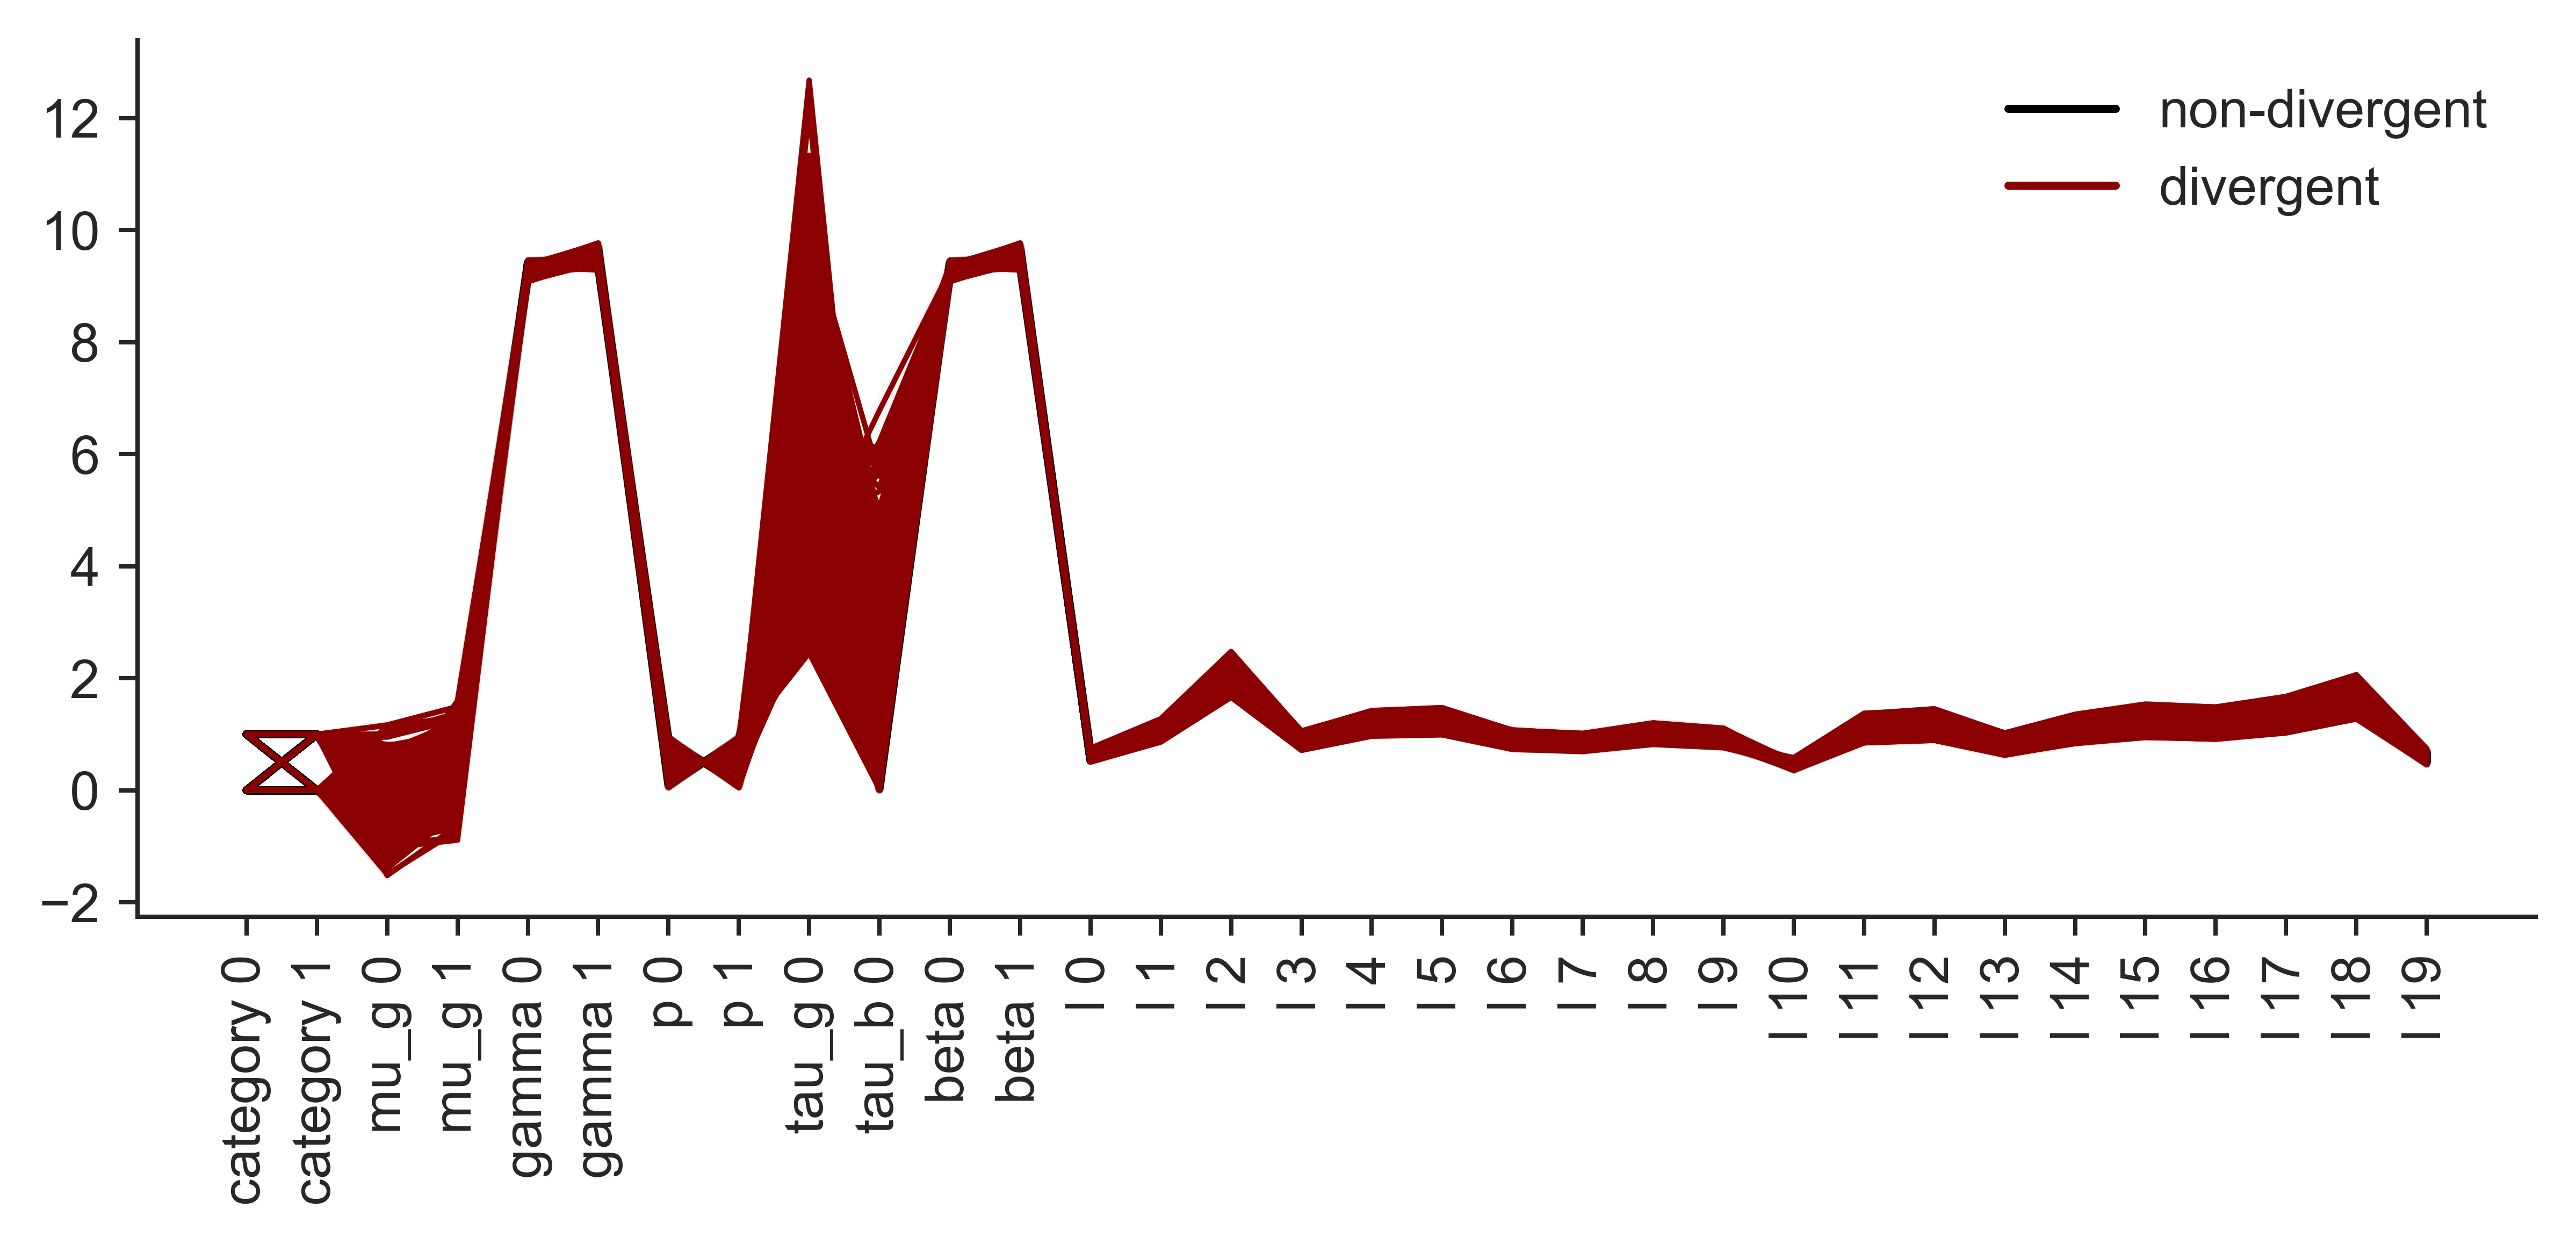

In [461]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=720)
ax.plot(_posterior[:, ~diverging_mask[lens]], color="black", alpha=0.025)

if np.any(diverging_mask):
    ax.plot(_posterior[:, diverging_mask[lens]], color="darkred", lw=1)

ax.set_xticks(range(len(var_names)))
ax.set_xticklabels(var_names)
plt.xticks(rotation=90)
ax.plot([], color="black", label="non-divergent")
if np.any(diverging_mask[lens]):
    ax.plot([], color="darkred", label="divergent")
ax.legend(frameon=False)
plt.show()

In [436]:
trace

<MultiTrace: 4 chains, 1500 iterations, 12 variables>